# Trainingsdaten-Analyse für ESCO Skill Retrieval

Dieses Notebook analysiert die verfügbaren Trainingsdaten um informierte Entscheidungen über:
- **Training-Task Auswahl** (Retrieval vs. Reranking vs. Classification)
- **Daten-Preprocessing und -formatierung**
- **Contrastive Learning Setup**
- **Synthetische Datenerweiterung**

## Ziele:
1. 📊 Datenverteilung über verschiedene Domains analysieren
2. 🔍 Thematische Clustering zur Identifikation von Bereichen
3. ⚖️ Label-Balance und Datenqualität bewerten
4. 🎯 Gaps identifizieren für synthetische Daten
5. 💡 Training-Strategien ableiten

In [1]:
# Import Required Libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Text processing and NLP
import re
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Sentence transformers for embeddings
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("⚠️  sentence-transformers nicht installiert. Verwende TF-IDF für Embeddings.")
    SENTENCE_TRANSFORMERS_AVAILABLE = False

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 📂 Datenquellen laden und explorieren

Wir laden alle verfügbaren Trainingsdaten und analysieren deren Struktur:

In [3]:
# Datenpfade definieren
data_dir = Path("../../data")

# Alle verfügbaren JSON-Dateien identifizieren
data_files = {
    # ESCO Dateien
    # "esco_skills": data_dir / "ESCO" / "esco_skills_v120_de.json",
    # "greta2esco": data_dir / "ESCO" / "greta2esco.json", 
    # "myedulife_esco": data_dir / "ESCO" / "myedulife_esco.json",
    # "wisy_validated_v1": data_dir / "ESCO" / "wisy_validated.json",
    # "wisy_validated_v2": data_dir / "ESCO" / "wisy_validated_240704.json",
    # "wisy_validated_v3": data_dir / "ESCO" / "esco_wisy_validated_250924.json",  # Neue 500 Samples!
    # "esco_frequent_labels_reduced": data_dir / "ESCO" / "augmented" / "reduced_and_compressed.json",
    "esco_rare_lables_supplements": data_dir / "ESCO" / "augmented" / "combinedESCOAugmentedExpanded.json",
    
    # GRETA Dateien  
    # "greta_v2": data_dir / "GRETA" / "greta.json",
    # "greta_wbs_jan": data_dir / "GRETA" / "greta_wbs_240102.json",
    # "greta_wbs_may": data_dir / "GRETA" / "greta_wbs_240502.json", 
    # "greta_wbs_may2": data_dir / "GRETA" / "greta_wbs_240507.json",
    # "greta_eule": data_dir / "GRETA" / "greta_eule.json",
    # "greta_validated": data_dir / "GRETA" / "validated_greta_240704.json"
}

# Prüfe welche Dateien existieren
available_files = {}
for name, path in data_files.items():
    if path.exists():
        available_files[name] = path
        print(f"✅ {name}: {path}")
    else:
        print(f"❌ {name}: {path} (nicht gefunden)")

print(f"\n📁 {len(available_files)} von {len(data_files)} Dateien gefunden")

✅ esco_rare_lables_supplements: ..\..\data\ESCO\augmented\combinedESCOAugmentedExpanded.json

📁 1 von 1 Dateien gefunden


In [4]:
# Funktion zum Laden und Analysieren der JSON-Struktur
def load_and_analyze_json(file_path, name):
    """Lädt JSON-Datei und analysiert deren Struktur"""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print(f"\n🔍 Analyse: {name}")
    print(f"   Typ: {type(data)}")
    
    if isinstance(data, list) and len(data) > 0:
        print(f"   Anzahl Einträge: {len(data)}")
        print(f"   Beispiel-Struktur: {list(data[0].keys()) if isinstance(data[0], dict) else 'Nicht-Dict'}")
        
        # Analysiere typische Felder
        if isinstance(data[0], dict):
            sample = data[0]
            for key, value in sample.items():
                value_type = type(value).__name__
                if isinstance(value, list):
                    value_info = f"list[{len(value)}]"
                elif isinstance(value, str):
                    value_info = f"str[{len(value)}]" if len(value) < 100 else f"str[{len(value)}...]"
                else:
                    value_info = value_type
                print(f"   - {key}: {value_info}")
    
    elif isinstance(data, dict):
        print(f"   Keys: {list(data.keys())}")
    
    return data

# Lade alle verfügbaren Dateien
datasets = {}
for name, path in available_files.items():
    try:
        datasets[name] = load_and_analyze_json(path, name)
    except Exception as e:
        print(f"❌ Fehler beim Laden von {name}: {e}")

print(f"\n📊 {len(datasets)} Datensätze erfolgreich geladen")


🔍 Analyse: esco_rare_lables_supplements
   Typ: <class 'list'>
   Anzahl Einträge: 6024
   Beispiel-Struktur: ['query', 'pos', 'neg']
   - query: str[163...]
   - pos: list[1]
   - neg: list[2]

📊 1 Datensätze erfolgreich geladen


In [5]:
# Standardisierte Datenstruktur erstellen für Analyse
def standardize_dataset(data, dataset_name):
    """Konvertiert verschiedene Datenformate in einheitliche Struktur"""
    standardized = []
    
    for item in data:
        if isinstance(item, dict):
            # Extrahiere query, positive und negative labels
            query = ""
            pos_labels = []
            neg_labels = []
            metadata = {"source": dataset_name}
            
            # Identifiziere query field (verschiedene Varianten)
            for query_field in ["query", "text", "description", "title", "course_description"]:
                if query_field in item:
                    query = item[query_field]
                    break
            
            # Identifiziere positive labels 
            for pos_field in ["pos", "positive", "labels", "skills", "competences"]:
                if pos_field in item and item[pos_field]:
                    if isinstance(item[pos_field], list):
                        pos_labels = item[pos_field]
                    else:
                        pos_labels = [item[pos_field]]
                    break
            
            # Identifiziere negative labels
            for neg_field in ["neg", "negative", "hard_negatives"]:
                if neg_field in item and item[neg_field]:
                    if isinstance(item[neg_field], list):
                        neg_labels = item[neg_field]
                    else:
                        neg_labels = [item[neg_field]]
                    break
            
            # Zusätzliche Metadaten sammeln
            for key, value in item.items():
                if key not in ["query", "text", "description", "title", "course_description", 
                             "pos", "positive", "labels", "skills", "competences",
                             "neg", "negative", "hard_negatives"]:
                    metadata[key] = value
            
            if query and pos_labels:  # Nur wenn query und positive labels vorhanden
                standardized.append({
                    "query": str(query),
                    "positive_labels": pos_labels,
                    "negative_labels": neg_labels,
                    "metadata": metadata
                })
    
    return standardized

# Standardisiere alle Datensätze
standardized_datasets = {}
total_samples = 0

for name, data in datasets.items():
    if isinstance(data, list):
        standardized = standardize_dataset(data, name)
        standardized_datasets[name] = standardized
        total_samples += len(standardized)
        print(f"📝 {name}: {len(standardized)} Samples standardisiert")

print(f"\n🔢 Gesamt: {total_samples} verwendbare Trainings-Samples")

📝 esco_rare_lables_supplements: 6024 Samples standardisiert

🔢 Gesamt: 6024 verwendbare Trainings-Samples


## 📏 Detaillierte Längenanalyse

Analysieren wir die Textlängen von Queries und Labels für Modell-Kontextlänge und Trainingsstrategie:

📏 Detaillierte Längenanalyse von Queries und Labels

📊 LÄNGENSTATISTIKEN ÜBERBLICK:

🔍 QUERIES (6024 Texte):
   Wörter: Ø 30.0 (Min: 1, Max: 237)
   Zeichen: Ø 261.1 (Min: 23, Max: 1587)
   Percentile (Wörter): 90% < 51.0, 95% < 67.0, 99% < 145.0

✅ POSITIVE LABELS (9726 Texte):
   Wörter: Ø 24.8 (Min: 1, Max: 95)
   Zeichen: Ø 216.7 (Min: 7, Max: 823)
   Percentile (Wörter): 90% < 40.0, 95% < 46.0

❌ NEGATIVE LABELS (19625 Texte):
   Wörter: Ø 24.5 (Min: 1, Max: 95)
   Zeichen: Ø 213.2 (Min: 7, Max: 823)
   Percentile (Wörter): 90% < 40.0, 95% < 45.0

⚖️ QUERY-LABEL LÄNGENVERHÄLTNIS:
   Query/Positive Label Ratio: 1.2:1
   → Queries sind im Durchschnitt 1.2x länger als positive Labels
   Query/Negative Label Ratio: 1.2:1


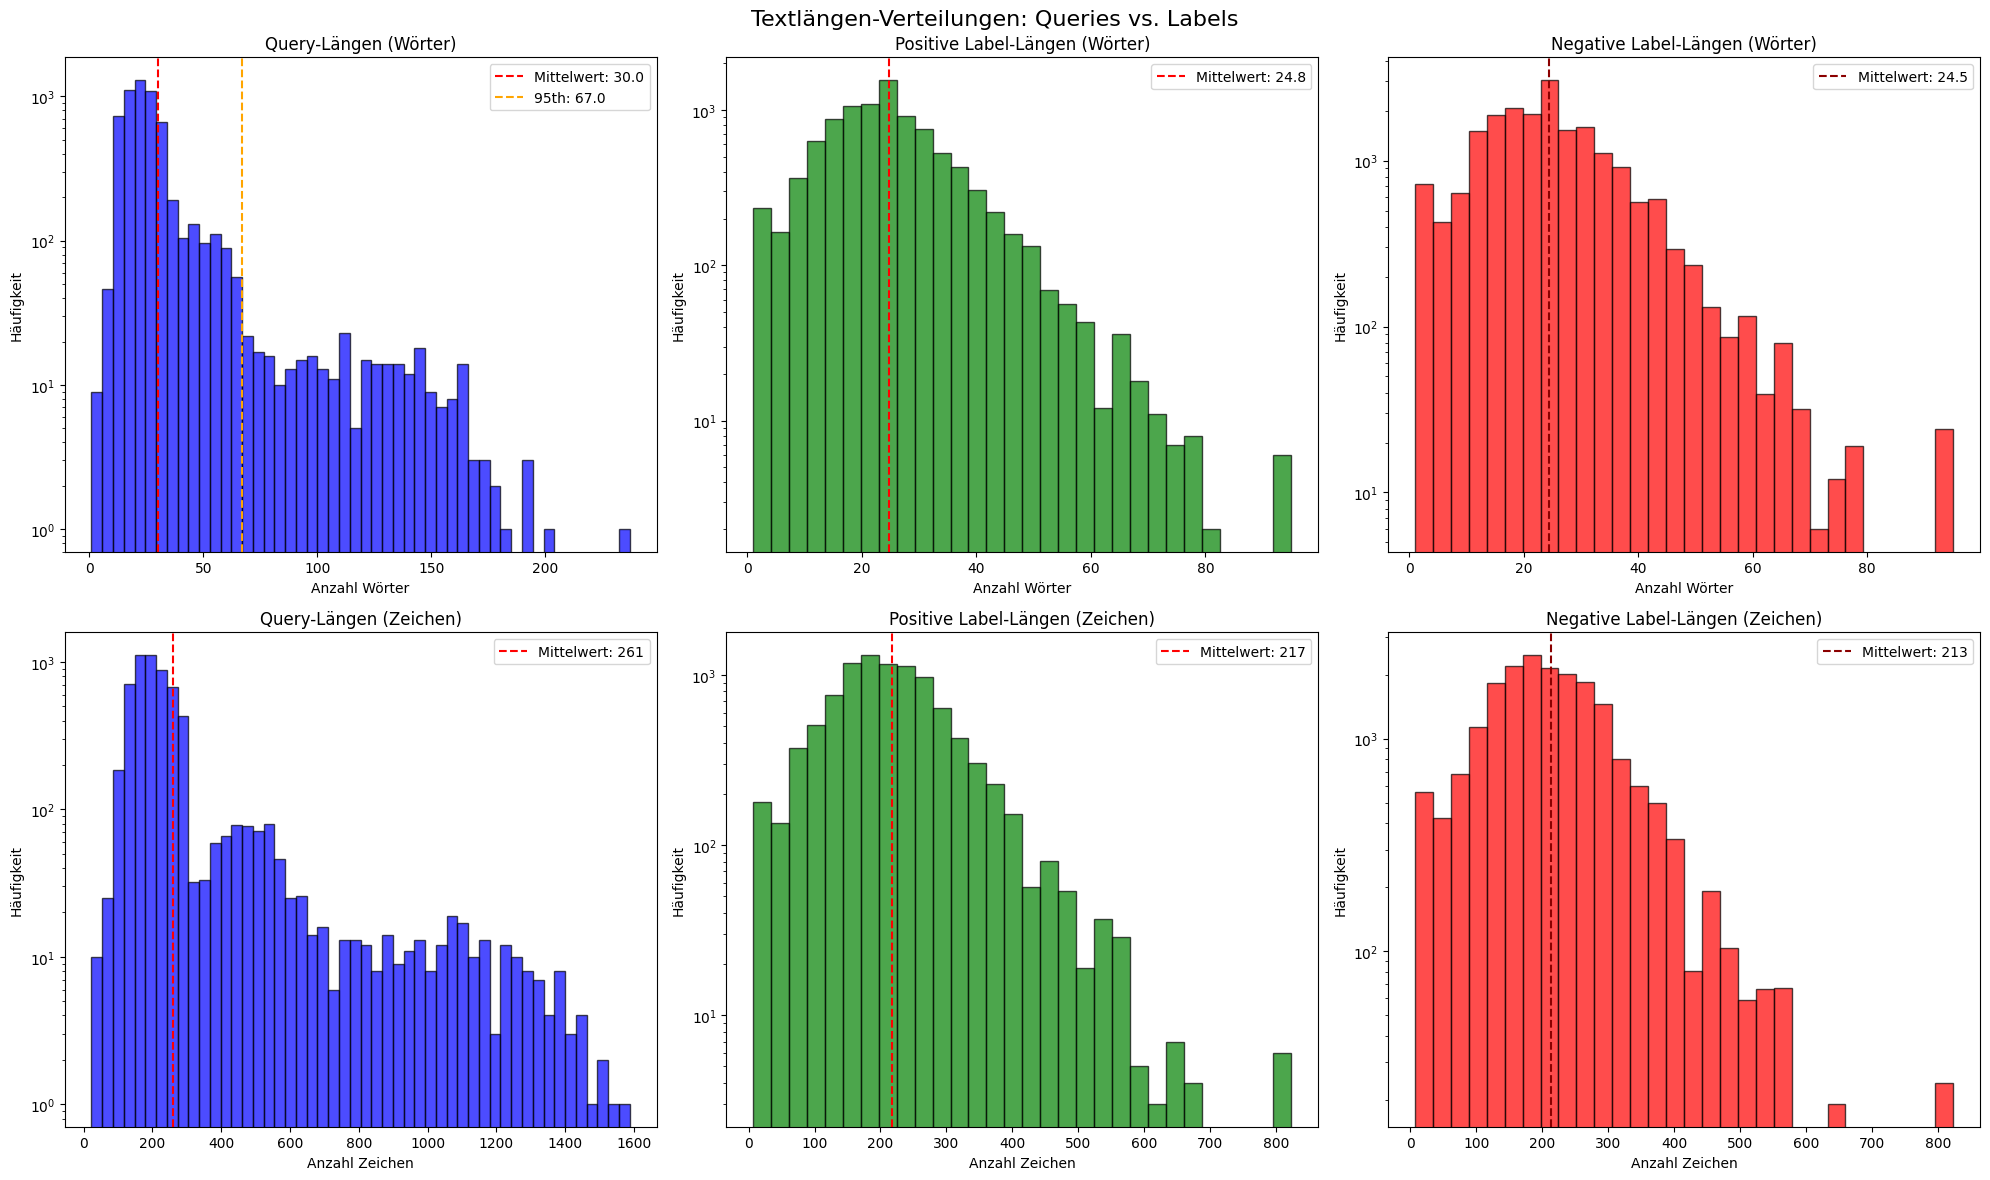

In [6]:
# Umfassende Längenanalyse für Modell-Kontextlänge und Trainingsstrategie
print("📏 Detaillierte Längenanalyse von Queries und Labels")
print("=" * 60)

# Sammle alle Texte für Längenanalyse
all_query_texts = []
all_pos_label_texts = []
all_neg_label_texts = []
length_metadata = []

for dataset_name, samples in standardized_datasets.items():
    for sample in samples:
        query_text = sample["query"]
        all_query_texts.append(query_text)
        
        # Positive Labels
        for pos_label in sample["positive_labels"]:
            all_pos_label_texts.append(str(pos_label))
        
        # Negative Labels  
        for neg_label in sample["negative_labels"]:
            all_neg_label_texts.append(str(neg_label))
        
        # Metadaten für diesen Sample sammeln
        length_metadata.append({
            "dataset": dataset_name,
            "query_length_words": len(query_text.split()),
            "query_length_chars": len(query_text),
            "num_pos_labels": len(sample["positive_labels"]),
            "num_neg_labels": len(sample["negative_labels"]),
            "avg_pos_label_length": np.mean([len(str(label).split()) for label in sample["positive_labels"]]) if sample["positive_labels"] else 0,
            "avg_neg_label_length": np.mean([len(str(label).split()) for label in sample["negative_labels"]]) if sample["negative_labels"] else 0
        })

# Berechne Längenstatistiken
def calculate_length_stats(texts, text_type):
    """Berechnet umfassende Längenstatistiken"""
    if not texts:
        return None
    
    word_lengths = [len(str(text).split()) for text in texts]
    char_lengths = [len(str(text)) for text in texts]
    
    stats = {
        "count": len(texts),
        "words": {
            "min": min(word_lengths),
            "max": max(word_lengths), 
            "mean": np.mean(word_lengths),
            "median": np.median(word_lengths),
            "std": np.std(word_lengths),
            "percentiles": {
                "25th": np.percentile(word_lengths, 25),
                "75th": np.percentile(word_lengths, 75),
                "90th": np.percentile(word_lengths, 90),
                "95th": np.percentile(word_lengths, 95),
                "99th": np.percentile(word_lengths, 99)
            }
        },
        "chars": {
            "min": min(char_lengths),
            "max": max(char_lengths),
            "mean": np.mean(char_lengths),
            "median": np.median(char_lengths),
            "std": np.std(char_lengths)
        }
    }
    return stats, word_lengths, char_lengths

# Statistiken für alle Text-Typen
query_stats, query_word_lens, query_char_lens = calculate_length_stats(all_query_texts, "Queries")
pos_label_stats, pos_word_lens, pos_char_lens = calculate_length_stats(all_pos_label_texts, "Positive Labels")

neg_label_stats = None
neg_word_lens = []
neg_char_lens = []
if all_neg_label_texts:
    neg_label_stats, neg_word_lens, neg_char_lens = calculate_length_stats(all_neg_label_texts, "Negative Labels")

# Ausgabe der Statistiken
print(f"\n📊 LÄNGENSTATISTIKEN ÜBERBLICK:")
print(f"{'='*50}")

print(f"\n🔍 QUERIES ({query_stats['count']} Texte):")
print(f"   Wörter: Ø {query_stats['words']['mean']:.1f} (Min: {query_stats['words']['min']}, Max: {query_stats['words']['max']})")
print(f"   Zeichen: Ø {query_stats['chars']['mean']:.1f} (Min: {query_stats['chars']['min']}, Max: {query_stats['chars']['max']})")
print(f"   Percentile (Wörter): 90% < {query_stats['words']['percentiles']['90th']:.1f}, 95% < {query_stats['words']['percentiles']['95th']:.1f}, 99% < {query_stats['words']['percentiles']['99th']:.1f}")

print(f"\n✅ POSITIVE LABELS ({pos_label_stats['count']} Texte):")
print(f"   Wörter: Ø {pos_label_stats['words']['mean']:.1f} (Min: {pos_label_stats['words']['min']}, Max: {pos_label_stats['words']['max']})")
print(f"   Zeichen: Ø {pos_label_stats['chars']['mean']:.1f} (Min: {pos_label_stats['chars']['min']}, Max: {pos_label_stats['chars']['max']})")
print(f"   Percentile (Wörter): 90% < {pos_label_stats['words']['percentiles']['90th']:.1f}, 95% < {pos_label_stats['words']['percentiles']['95th']:.1f}")

if neg_label_stats:
    print(f"\n❌ NEGATIVE LABELS ({neg_label_stats['count']} Texte):")
    print(f"   Wörter: Ø {neg_label_stats['words']['mean']:.1f} (Min: {neg_label_stats['words']['min']}, Max: {neg_label_stats['words']['max']})")
    print(f"   Zeichen: Ø {neg_label_stats['chars']['mean']:.1f} (Min: {neg_label_stats['chars']['min']}, Max: {neg_label_stats['chars']['max']})")
    print(f"   Percentile (Wörter): 90% < {neg_label_stats['words']['percentiles']['90th']:.1f}, 95% < {neg_label_stats['words']['percentiles']['95th']:.1f}")

# Längen-Verhältnis-Analyse
query_label_ratio = query_stats['words']['mean'] / pos_label_stats['words']['mean']
print(f"\n⚖️ QUERY-LABEL LÄNGENVERHÄLTNIS:")
print(f"   Query/Positive Label Ratio: {query_label_ratio:.1f}:1")
print(f"   → Queries sind im Durchschnitt {query_label_ratio:.1f}x länger als positive Labels")

if neg_label_stats:
    query_neg_ratio = query_stats['words']['mean'] / neg_label_stats['words']['mean']  
    print(f"   Query/Negative Label Ratio: {query_neg_ratio:.1f}:1")

# Visualisierung der Längenverteilungen
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Textlängen-Verteilungen: Queries vs. Labels', fontsize=16)

# Query-Längen (Wörter)
axes[0,0].hist(query_word_lens, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].axvline(query_stats['words']['mean'], color='red', linestyle='--', label=f'Mittelwert: {query_stats["words"]["mean"]:.1f}')
axes[0,0].axvline(query_stats['words']['percentiles']['95th'], color='orange', linestyle='--', label=f'95th: {query_stats["words"]["percentiles"]["95th"]:.1f}')
axes[0,0].set_xlabel('Anzahl Wörter')
axes[0,0].set_ylabel('Häufigkeit')
axes[0,0].set_title('Query-Längen (Wörter)')
axes[0,0].legend()
axes[0,0].set_yscale('log')

# Positive Label-Längen (Wörter)
axes[0,1].hist(pos_word_lens, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0,1].axvline(pos_label_stats['words']['mean'], color='red', linestyle='--', label=f'Mittelwert: {pos_label_stats["words"]["mean"]:.1f}')
axes[0,1].set_xlabel('Anzahl Wörter')
axes[0,1].set_ylabel('Häufigkeit')
axes[0,1].set_title('Positive Label-Längen (Wörter)')
axes[0,1].legend()
axes[0,1].set_yscale('log')

# Negative Label-Längen (Wörter)
if neg_word_lens:
    axes[0,2].hist(neg_word_lens, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0,2].axvline(neg_label_stats['words']['mean'], color='darkred', linestyle='--', label=f'Mittelwert: {neg_label_stats["words"]["mean"]:.1f}')
    axes[0,2].set_xlabel('Anzahl Wörter')
    axes[0,2].set_ylabel('Häufigkeit')  
    axes[0,2].set_title('Negative Label-Längen (Wörter)')
    axes[0,2].legend()
    axes[0,2].set_yscale('log')
else:
    axes[0,2].text(0.5, 0.5, 'Keine negativen\nLabels verfügbar', ha='center', va='center', transform=axes[0,2].transAxes)
    axes[0,2].set_title('Negative Label-Längen')

# Zeichen-basierte Verteilungen
axes[1,0].hist(query_char_lens, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1,0].axvline(query_stats['chars']['mean'], color='red', linestyle='--', label=f'Mittelwert: {query_stats["chars"]["mean"]:.0f}')
axes[1,0].set_xlabel('Anzahl Zeichen')
axes[1,0].set_ylabel('Häufigkeit')
axes[1,0].set_title('Query-Längen (Zeichen)')
axes[1,0].legend()
axes[1,0].set_yscale('log')

axes[1,1].hist(pos_char_lens, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,1].axvline(pos_label_stats['chars']['mean'], color='red', linestyle='--', label=f'Mittelwert: {pos_label_stats["chars"]["mean"]:.0f}')
axes[1,1].set_xlabel('Anzahl Zeichen')
axes[1,1].set_ylabel('Häufigkeit')
axes[1,1].set_title('Positive Label-Längen (Zeichen)')
axes[1,1].legend()
axes[1,1].set_yscale('log')

if neg_char_lens:
    axes[1,2].hist(neg_char_lens, bins=30, alpha=0.7, color='red', edgecolor='black')  
    axes[1,2].axvline(neg_label_stats['chars']['mean'], color='darkred', linestyle='--', label=f'Mittelwert: {neg_label_stats["chars"]["mean"]:.0f}')
    axes[1,2].set_xlabel('Anzahl Zeichen')
    axes[1,2].set_ylabel('Häufigkeit')
    axes[1,2].set_title('Negative Label-Längen (Zeichen)')
    axes[1,2].legend() 
    axes[1,2].set_yscale('log')
else:
    axes[1,2].text(0.5, 0.5, 'Keine negativen\nLabels verfügbar', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Negative Label-Längen')

plt.tight_layout()
plt.show()

In [7]:
# Modell-Kontextlängen-Empfehlungen basierend auf Längenanalyse
print(f"\n🎯 MODELL-KONTEXTLÄNGEN-EMPFEHLUNGEN:")
print("=" * 50)

# Kontextlängen-Analyse für verschiedene Coverage-Level
coverage_levels = [90, 95, 99]
max_query_words = query_stats['words']['max']
max_label_words = pos_label_stats['words']['max']

for coverage in coverage_levels:
    query_cutoff = query_stats['words']['percentiles'][f'{coverage}th']
    
    # Berücksichtige auch Token-Overhead (ca. 1.3x für deutsche Texte)
    token_overhead = 1.3
    estimated_tokens_query = query_cutoff * token_overhead
    
    # Für Bi-Encoder: Query und Label separat
    # Für Cross-Encoder: Query + Label zusammen
    estimated_tokens_cross_encoder = estimated_tokens_query + (pos_label_stats['words']['mean'] * token_overhead)
    
    print(f"\n📊 {coverage}% Coverage:")
    print(f"   Max Query-Länge: {query_cutoff:.0f} Wörter (~{estimated_tokens_query:.0f} Tokens)")
    print(f"   Bi-Encoder Kontext: {estimated_tokens_query:.0f} Tokens pro Eingabe")
    print(f"   Cross-Encoder Kontext: ~{estimated_tokens_cross_encoder:.0f} Tokens (Query+Label)")

# Spezifische Modell-Empfehlungen
print(f"\n🔧 SPEZIFISCHE MODELL-EMPFEHLUNGEN:")

query_99th = query_stats['words']['percentiles']['99th'] * 1.3  # Token estimate
if query_99th <= 256:
    print(f"✅ Kurze Kontexte: Modelle mit 256-512 Token Limit ausreichend")
    print(f"   → multilingual-e5-base (512 tokens), distilbert-base (512 tokens)")
elif query_99th <= 512:
    print(f"✅ Mittlere Kontexte: Modelle mit 512 Token Limit empfohlen") 
    print(f"   → multilingual-e5-base (512 tokens), sentence-transformers Standard")
else:
    print(f"⚠️  Lange Kontexte: Modelle mit >512 Token Limit nötig")
    print(f"   → e5-mistral-7b-instruct (4096 tokens), BGE-M3 (8192 tokens)")
    print(f"   → Oder Query-Chunking implementieren")

# Training-spezifische Überlegungen
print(f"\n🎓 TRAINING-STRATEGISCHE IMPLIKATIONEN:")
print("=" * 45)

print(f"1. ASYMMETRISCHE LÄNGEN:")
print(f"   - Queries: {query_stats['words']['mean']:.1f} Wörter (Ø)")
print(f"   - Labels: {pos_label_stats['words']['mean']:.1f} Wörter (Ø)")
print(f"   - Verhältnis: {query_label_ratio:.1f}:1")
print(f"   → Asymmetrische Architekturen könnten vorteilhaft sein")

print(f"\n2. KONTRASTIVE LEARNING ÜBERLEGUNGEN:")
if query_label_ratio > 10:
    print(f"   ⚠️  Sehr asymmetrische Längen (>{query_label_ratio:.0f}:1)")
    print(f"   → Separate Encoder für Queries vs. Labels empfohlen")
    print(f"   → Temperature Scaling für Ähnlichkeits-Scores")
    print(f"   → Unterschiedliche Learning Rates für Query/Label Encoder")
elif query_label_ratio > 5:
    print(f"   📊 Moderate Asymmetrie ({query_label_ratio:.1f}:1)")  
    print(f"   → Shared Encoder möglich, aber Normalization wichtig")
else:
    print(f"   ✅ Ähnliche Längen ({query_label_ratio:.1f}:1)")
    print(f"   → Standard Contrastive Learning Setup geeignet")

print(f"\n3. DATA AUGMENTATION STRATEGIEN:")
if query_stats['words']['std'] > query_stats['words']['mean'] * 0.5:
    print(f"   📈 Hohe Längen-Varianz in Queries (σ={query_stats['words']['std']:.1f})")
    print(f"   → Length-aware Sampling empfohlen")
    print(f"   → Query-Truncation/Padding Strategien definieren")
else:
    print(f"   📊 Moderate Längen-Varianz")
    print(f"   → Standard Padding/Truncation ausreichend")

# Outlier-Detection für sehr lange/kurze Texte
very_long_queries = sum(1 for length in query_word_lens if length > query_stats['words']['percentiles']['99th'])
very_short_queries = sum(1 for length in query_word_lens if length < 5)
very_long_labels = sum(1 for length in pos_word_lens if length > 10)

print(f"\n🚨 OUTLIER-ANALYSE:")
print(f"   Sehr lange Queries (>{query_stats['words']['percentiles']['99th']:.0f} Wörter): {very_long_queries} ({(very_long_queries/len(query_word_lens)*100):.1f}%)")
print(f"   Sehr kurze Queries (<5 Wörter): {very_short_queries} ({(very_short_queries/len(query_word_lens)*100):.1f}%)")
print(f"   Sehr lange Labels (>10 Wörter): {very_long_labels} ({(very_long_labels/len(pos_word_lens)*100):.1f}%)")

if very_long_queries > len(query_word_lens) * 0.05:
    print(f"   ⚠️  >5% sehr lange Queries → Chunking-Strategie entwickeln")
if very_short_queries > len(query_word_lens) * 0.1:
    print(f"   ⚠️  >10% sehr kurze Queries → Padding/Minimum-Length Policy")

# Dataset-spezifische Längenanalyse
print(f"\n📋 DATASET-SPEZIFISCHE LÄNGEN:")
print("-" * 40)
length_df_data = []
for metadata in length_metadata:
    length_df_data.append(metadata)

length_df = pd.DataFrame(length_df_data)
dataset_length_summary = length_df.groupby('dataset').agg({
    'query_length_words': ['mean', 'std', 'max'],
    'avg_pos_label_length': 'mean'
}).round(1)

print(dataset_length_summary.to_string())

# Speichere Längen-Erkenntnisse
length_insights = {
    "query_stats": query_stats,
    "pos_label_stats": pos_label_stats,
    "neg_label_stats": neg_label_stats,
    "query_label_ratio": query_label_ratio,
    "recommended_context_length": int(query_stats['words']['percentiles']['95th'] * 1.3),
    "outliers": {
        "very_long_queries": very_long_queries,
        "very_short_queries": very_short_queries,
        "very_long_labels": very_long_labels
    }
}

print(f"\n💾 Längen-Insights verfügbar in Variable 'length_insights'")
print(f"✅ Modell-Kontextlängen-Analyse abgeschlossen!")


🎯 MODELL-KONTEXTLÄNGEN-EMPFEHLUNGEN:

📊 90% Coverage:
   Max Query-Länge: 51 Wörter (~66 Tokens)
   Bi-Encoder Kontext: 66 Tokens pro Eingabe
   Cross-Encoder Kontext: ~99 Tokens (Query+Label)

📊 95% Coverage:
   Max Query-Länge: 67 Wörter (~87 Tokens)
   Bi-Encoder Kontext: 87 Tokens pro Eingabe
   Cross-Encoder Kontext: ~119 Tokens (Query+Label)

📊 99% Coverage:
   Max Query-Länge: 145 Wörter (~188 Tokens)
   Bi-Encoder Kontext: 188 Tokens pro Eingabe
   Cross-Encoder Kontext: ~221 Tokens (Query+Label)

🔧 SPEZIFISCHE MODELL-EMPFEHLUNGEN:
✅ Kurze Kontexte: Modelle mit 256-512 Token Limit ausreichend
   → multilingual-e5-base (512 tokens), distilbert-base (512 tokens)

🎓 TRAINING-STRATEGISCHE IMPLIKATIONEN:
1. ASYMMETRISCHE LÄNGEN:
   - Queries: 30.0 Wörter (Ø)
   - Labels: 24.8 Wörter (Ø)
   - Verhältnis: 1.2:1
   → Asymmetrische Architekturen könnten vorteilhaft sein

2. KONTRASTIVE LEARNING ÜBERLEGUNGEN:
   ✅ Ähnliche Längen (1.2:1)
   → Standard Contrastive Learning Setup geeignet

## 🔍 Text-Preprocessing und Feature-Extraktion

Bereiten wir die Texte für die Analyse vor und extrahieren Features:

In [8]:
# Alle Queries sammeln für gemeinsame Analyse
all_queries = []
all_labels = []
query_metadata = []

for dataset_name, samples in standardized_datasets.items():
    for sample in samples:
        all_queries.append(sample["query"])
        
        # Sammle alle Labels (positive + negative)
        labels_for_sample = sample["positive_labels"] + sample["negative_labels"]
        all_labels.extend(labels_for_sample)
        
        query_metadata.append({
            "dataset": dataset_name,
            "num_pos": len(sample["positive_labels"]),
            "num_neg": len(sample["negative_labels"]),
            "query": sample["query"]
        })

print(f"📝 {len(all_queries)} Queries gesammelt")
print(f"🏷️  {len(all_labels)} Labels gesammelt")
print(f"🎯 {len(set(all_labels))} einzigartige Labels")

# Text-Preprocessing Funktion
def preprocess_text(text):
    """Einfache Textbereinigung für deutsche Texte"""
    # Kleinschreibung
    text = text.lower()
    
    # Entferne URLs, E-Mails etc.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    
    # Normalisiere Whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Preprocesse alle Queries
processed_queries = [preprocess_text(query) for query in all_queries]

print("✅ Text-Preprocessing abgeschlossen")

📝 6024 Queries gesammelt
🏷️  29351 Labels gesammelt
🎯 2550 einzigartige Labels
✅ Text-Preprocessing abgeschlossen


In [11]:

# Sentence Embeddings (falls verfügbar)
if SENTENCE_TRANSFORMERS_AVAILABLE:
    print("🔄 Lade Sentence Transformer für deutsche Texte...")
    
    # Verwende ein deutsches oder multilinguales Modell
    model_name = "intfloat/multilingual-e5-small"  # Leichtgewichtiges, schnelles Modell
    try:
        sentence_model = SentenceTransformer(model_name)
        print(f"✅ Sentence Transformer geladen: {model_name}")
        
        # Embeddings für Subset (um Speicher zu sparen)
        sample_size = len(processed_queries)
        sample_queries = processed_queries[:sample_size]
        
        print(f"🔄 Erstelle Embeddings für {sample_size} Samples...")
        sentence_embeddings = sentence_model.encode(sample_queries, show_progress_bar=True)
        print(f"✅ Sentence Embeddings: {sentence_embeddings.shape}")
        
    except Exception as e:
        print(f"❌ Fehler beim Laden des Sentence Transformers: {e}")
        SENTENCE_TRANSFORMERS_AVAILABLE = False
        sentence_embeddings = None
else:
    print("⚠️  Sentence Transformers nicht verfügbar, verwende nur TF-IDF.")
    sentence_embeddings = None

🔄 Lade Sentence Transformer für deutsche Texte...
✅ Sentence Transformer geladen: intfloat/multilingual-e5-small
🔄 Erstelle Embeddings für 6024 Samples...


Batches:   0%|          | 0/189 [00:00<?, ?it/s]

✅ Sentence Embeddings: (6024, 384)


## 🎯 Topic Modeling und Clustering

Identifizieren wir die Hauptthemenbereiche in den Daten:

## 🎯 Erweiterte ESCO-Kompetenz-Klassifikation (T, S, K, L)

Ergänzen wir die ISCED-F Analyse um die vollständige ESCO-Struktur für bessere Coverage der unklassifizierten Kurse:

In [12]:
# VOLLSTÄNDIGE ESCO-KLASSIFIKATION: T (Transversal), S (Skills), K (Knowledge), L (Language)
print("🎯 VOLLSTÄNDIGE ESCO-KOMPETENZ-KLASSIFIKATION")
print("=" * 60)

# Erweiterte ESCO-Kategorien basierend auf der vollständigen ESCO-Struktur
esco_categories = {
    # T - Querschnittsfähigkeiten und -kompetenzen (Transversal skills)
    # "T1": {
    #     "name_de": "Kernfähigkeiten und -kompetenzen",
    #     "name_en": "Thinking skills and competences", 
    #     "keywords": ["denken", "analysieren", "problem", "lösung", "kritisch", "logik", "reasoning", "analytical", 
    #                 "kreativität", "innovation", "idee", "brainstorming", "creative", "innovative", "lernfähigkeit",
    #                 "lernen", "learning", "anpassung", "flexibilität", "adaptability", "flexible"]
    # },
    # "T2": {
    #     "name_de": "Denkfähigkeiten und -kompetenzen", 
    #     "name_en": "Learning skills and competences",
    #     "keywords": ["studium", "weiterbildung", "fortbildung", "qualifikation", "zertifikat", "abschluss",
    #                 "methodik", "didaktik", "pädagogik", "lernstrategie", "wissensmanagement", "research",
    #                 "forschung", "wissenschaft", "akademisch", "academic", "methodology"]
    # },
    # Kombiniert T1 und T2 aufgrund schwieriger differenzierung
    "T1+T2": {
        "name_de": "Kognitive Fähigkeiten und Kompetenzen",
        "name_en": "Cognitive skills and competences",
        "keywords": ["denken", "analysieren", "problem", "lösung", "kritisch", "logik", "reasoning", "analytical", 
                    "kreativität", "innovation", "idee", "brainstorming", "creative", "innovative",
                    "studium", "weiterbildung", "fortbildung", "qualifikation", "zertifikat", "abschluss",
                    "methodik", "didaktik", "pädagogik", "lernstrategie", "wissensmanagement", "research",
                    "forschung", "wissenschaft", "akademisch", "academic", "methodology"]
    },
    "T3": {
        "name_de": "Selbstmanagement",
        "name_en": "Self-management skills and competences", 
        "keywords": ["selbstorganisation", "zeitmanagement", "planung", "organisation", "struktur", "disziplin",
                    "motivation", "selbstständig", "eigenverantwortung", "stress", "work-life", "balance",
                    "productivity", "efficiency", "goal", "ziel", "priorität", "priority"]
    },
    "T4": {
        "name_de": "Soziale und kommunikative",
        "name_en": "Social and communication skills and competences",
        "keywords": ["kommunikation", "gespräch", "präsentation", "rhetorik", "moderation", "mediation", "konflikt",
                    "team", "gruppe", "zusammenarbeit", "kooperation", "empathie", "sozial", "networking",
                    "kundenservice", "beratung", "coaching", "mentoring", "leadership", "führung"]
    },
    "T5": {
        "name_de": "Körperliche und manuelle",
        "name_en": "Physical and manual skills and competences",
        "keywords": ["handwerk", "manuell", "geschicklichkeit", "körperlich", "sport", "fitness", "bewegung",
                    "koordination", "balance", "kraft", "ausdauer", "precision", "genauigkeit", "feinmotorik",
                    "werkzeug", "handhabung", "manipulation", "assembly", "montage"]
    },
    "T6": {
        "name_de": "Aktive Bürgerschaft",
        "name_en": "Active citizenship skills and competences",
        "keywords": ["bürger", "demokratie", "politik", "gesellschaft", "gemeinschaft", "ehrenamt", "volunteer",
                    "nachhaltigkeit", "umwelt", "klima", "verantwortung", "ethik", "moral", "diversity",
                    "inklusion", "gleichberechtigung", "menschenrechte", "civic", "citizenship"]
    },
    
    # S - Fähigkeiten (Skills)  
    "S1": {
        "name_de": "Kommunikation, Zusammenarbeit und Kreativität",
        "name_en": "Communication, collaboration and creativity",
        "keywords": ["schreiben", "texten", "redaktion", "journalismus", "content", "copywriting", "storytelling",
                    "design", "grafik", "layout", "visualization", "präsentation", "public speaking",
                    "collaboration", "teamwork", "workshop", "facilitation"]
    },
    "S2": {
        "name_de": "Informationskompetenzen", 
        "name_en": "Information skills",
        "keywords": ["recherche", "information", "daten", "analyse", "auswertung", "statistik", "excel", "tableau",
                    "database", "datenbank", "bibliothek", "archiv", "dokumentation", "wissensmanagement",
                    "data mining", "business intelligence", "reporting", "dashboard"]
    },
    "S3": {
        "name_de": "Unterstützung und Pflege",
        "name_en": "Assisting and caring",
        "keywords": ["pflege", "betreuung", "unterstützung", "hilfe", "assistenz", "service", "kundenbetreuung",
                    "sozialarbeit", "therapie", "rehabilitation", "coaching", "mentoring", "training",
                    "ausbildung", "support", "care", "assistance"]
    },
    "S4": {
        "name_de": "Managementfähigkeiten",
        "name_en": "Management skills", 
        "keywords": ["management", "führung", "leitung", "direktion", "projektmanagement", "prozess", "strategie",
                    "planung", "controlling", "budgetierung", "personal", "hr", "rekrutierung", "performance",
                    "qualitätsmanagement", "risikomanagement", "change management", "transformation"]
    },
    "S5": {
        "name_de": "Arbeiten mit Computern",
        "name_en": "Working with computers",
        "keywords": ["computer", "pc", "software", "anwendung", "office", "word", "powerpoint", "outlook",
                    "internet", "browser", "email", "digital", "online", "cloud", "backup", "security",
                    "troubleshooting", "installation", "konfiguration", "update"]
    },
    "S6": {
        "name_de": "Handhabung/Transport und Bewegung",
        "name_en": "Handling/Transport and movement",
        "keywords": ["transport", "logistik", "versand", "lieferung", "lager", "warehouse", "supply chain",
                    "fahrzeug", "lkw", "gabelstapler", "kran", "heben", "bewegen", "handling", "manipulation",
                    "verpackung", "packaging", "distribution", "spedition"]
    },
    "S7": {
        "name_de": "Bau", 
        "name_en": "Construction",
        "keywords": ["bau", "bauen", "konstruktion", "architektur", "planung", "entwurf", "zeichnung", "cad",
                    "handwerk", "maurer", "zimmermann", "elektriker", "installation", "montage", "renovation",
                    "sanierung", "instandhaltung", "wartung", "reparatur", "maintenance"]
    },
    "S8": {
        "name_de": "Arbeiten mit Maschinen und Spezialausrüstungen",
        "name_en": "Working with machines and specialized equipment",
        "keywords": ["maschine", "ausrüstung", "equipment", "technische", "bedienung", "steuerung", "wartung",
                    "reparatur", "instandhaltung", "cnc", "automation", "roboter", "produktionsanlage",
                    "fertigungsanlage", "qualitätskontrolle", "prüfung", "messung", "kalibrierung"]
    },
    
    # K - Kenntnisse (Knowledge - ISCED-F detailed)
    # "K00": {"name_de": "Allgemeine Bildungsprogramme und Qualifikationen", "keywords": ["allgemein", "grundbildung", "schulabschluss", "abitur", "realschule", "hauptschule", "gymnasium"]},
    "K01": {"name_de": "Erziehungswissenschaften", "keywords": ["bildung", "pädagogik", "didaktik", "lehre", "unterricht", "ausbildung", "erziehung", "bildungswesen"]},
    "K02": {"name_de": "Kunst und Geisteswissenschaften", "keywords": ["kunst", "kultur", "geschichte", "sprache", "literatur", "philosophie", "musik", "theater", "malerei"]},
    "K03": {"name_de": "Sozialwissenschaften, Journalistik und Informationswissenschaft", "keywords": ["sozial", "gesellschaft", "politik", "journalismus", "medien", "information", "soziologie", "psychologie"]},
    "K04": {"name_de": "Wirtschaft, Verwaltung und Rechtswissenschaft", "keywords": ["wirtschaft", "business", "management", "verwaltung", "recht", "jura", "legal", "betriebswirtschaft", "volkswirtschaft"]},
    "K05": {"name_de": "Naturwissenschaften, Mathematik und Statistik", "keywords": ["mathematik", "physik", "chemie", "biologie", "naturwissenschaft", "wissenschaft", "statistik", "forschung"]},
    "K06": {"name_de": "Informations- und Kommunikationstechnologien (IKT)", "keywords": ["computer", "software", "programmierung", "it", "digital", "technologie", "internet", "informatik", "entwicklung"]},
    "K07": {"name_de": "Ingenieurwesen, Fertigung und Bauwesen", "keywords": ["ingenieur", "technik", "produktion", "fertigung", "bau", "konstruktion", "maschinenbau", "elektrotechnik"]},
    "K08": {"name_de": "Agrarwissenschaft, Forstwissenschaft, Fischereiwirtschaft und Veterinärwissenschaft", "keywords": ["landwirtschaft", "agrar", "forst", "tier", "veterinär", "natur", "umwelt", "ökologie"]},
    "K09": {"name_de": "Gesundheit und soziale Dienste", "keywords": ["gesundheit", "medizin", "pflege", "therapie", "sozial", "betreuung", "krankenhaus", "arzt", "krankenschwester"]},
    "K10": {"name_de": "Dienstleistungen", "keywords": ["service", "dienstleistung", "tourismus", "gastronomie", "handel", "verkauf", "einzelhandel", "restaurant"]},
    # "K99": {"name_de": "Bereich nicht bekannt", "keywords": ["unbekannt", "sonstige", "andere", "diverse", "verschiedene", "allgemein"]},
    
    # L - Sprachliche Fähigkeiten und Kenntnisse (Language skills)
    "L": {
        "name_de": "Sprachliche Fähigkeiten und Kenntnisse",
        "name_en": "Language skills and knowledge",
        "keywords": ["sprache", "english", "französisch", "spanisch", "italienisch", "russisch", "chinesisch",
                    "deutsch", "kommunikation", "übersetzung", "dolmetschen", "interpretation", "fremdsprache",
                    "mehrsprachig", "bilingual", "multilingual", "intercultural", "international", "global",
                    "language", "linguistic", "grammar", "vocabulary", "pronunciation", "fluency"]
    }
}

print(f"📚 ESCO-Kategorien definiert:")
print(f"   • T-Kategorien (Transversal): {len([k for k in esco_categories.keys() if k.startswith('T')])}")
print(f"   • S-Kategorien (Skills): {len([k for k in esco_categories.keys() if k.startswith('S')])}")
print(f"   • K-Kategorien (Knowledge):  {len([k for k in esco_categories.keys() if k.startswith('K')])}")
print(f"   • L-Kategorien (Language): {len([k for k in esco_categories.keys() if k.startswith('L')])}")
print(f"   • Gesamt: {len(esco_categories)} ESCO-Kategorien")

# Erweiterte Klassifikationsfunktion für alle ESCO-Kategorien
def classify_esco_comprehensive(text, esco_categories, min_confidence=0.05):
    """Umfassende ESCO-Klassifikation (T, S, K, L)"""
    text_lower = text.lower()
    category_scores = {}
    
    for category_code, category_info in esco_categories.items():
        score = 0
        matched_keywords = []
        
        for keyword in category_info["keywords"]:
            if keyword in text_lower:
                # Spezielle Gewichtung für verschiedene Kategorietypen
                if category_code.startswith('T'):  # Transversal skills - oft implizit
                    weight = 1.5
                elif category_code.startswith('S'):  # Specific skills - meist explizit
                    weight = 2.0
                elif category_code.startswith('K'):  # Knowledge - fachspezifisch
                    weight = 2.5
                elif category_code.startswith('L'):  # Language - sehr spezifisch
                    weight = 3.0
                else:
                    weight = 1.0
                
                keyword_weight = len(keyword.split()) * weight
                score += keyword_weight
                matched_keywords.append(keyword)
        
        if score > 0:
            normalized_score = score / len(text_lower.split())
            category_scores[category_code] = {
                'score': normalized_score,
                'raw_score': score,
                'matched_keywords': matched_keywords,
                'name_de': category_info["name_de"],
                'category_type': category_code[0]  # T, S, K, oder L
            }
    
    if category_scores:
        sorted_categories = sorted(category_scores.items(), key=lambda x: x[1]['score'], reverse=True)
        
        # Verschiedene Confidence-Thresholds für verschiedene Kategorietypen
        filtered_results = []
        for cat_code, cat_info in sorted_categories:
            category_type = cat_info['category_type']
            threshold = {
                'T': 0.03,  # Niedrigere Threshold für Transversal (oft implizit)
                'S': 0.05,  # Standard Threshold für Skills
                'K': 0.08,  # Höhere Threshold für Knowledge (spezifischer)
                'L': 0.10   # Höchste Threshold für Language (sehr spezifisch)
            }.get(category_type, min_confidence)
            
            if cat_info['score'] >= threshold:
                filtered_results.append((cat_code, cat_info))
        
        return filtered_results if filtered_results else None
    
    return None

print("🔄 Re-klassifiziere alle Queries mit vollständiger ESCO-Struktur...")

# Re-klassifiziere alle Queries mit der erweiterten ESCO-Struktur
comprehensive_classifications = []
for i, query in enumerate(all_queries):
    # Query-Klassifikation
    query_classification = classify_esco_comprehensive(query, esco_categories)
    
    # Label-Klassifikation
    query_labels = []
    for dataset_name, samples in standardized_datasets.items():
        for sample in samples:
            if sample["query"] == query:
                query_labels.extend(sample["positive_labels"])
                break
    
    label_text = " ".join(query_labels) if query_labels else ""
    label_classification = classify_esco_comprehensive(label_text, esco_categories) if label_text else None
    
    comprehensive_classifications.append({
        'query_index': i,
        'query': query[:100] + "..." if len(query) > 100 else query,
        'labels': query_labels[:5],
        'query_classification': query_classification,
        'label_classification': label_classification,
        'final_classification': None
    })

# Kombiniere Query- und Label-Klassifikationen mit Gewichtung
for item in comprehensive_classifications:
    combined_scores = {}
    
    # Query-Scores
    if item['query_classification']:
        for cat_code, info in item['query_classification']:
            if cat_code not in combined_scores:
                combined_scores[cat_code] = {
                    'total_score': 0,
                    'sources': [],
                    'name_de': info['name_de'],
                    'category_type': info['category_type']
                }
            combined_scores[cat_code]['total_score'] += info['score']
            combined_scores[cat_code]['sources'].append('query')
    
    # Label-Scores (höhere Gewichtung)
    if item['label_classification']:
        for cat_code, info in item['label_classification']:
            if cat_code not in combined_scores:
                combined_scores[cat_code] = {
                    'total_score': 0,
                    'sources': [],
                    'name_de': info['name_de'],
                    'category_type': info['category_type']
                }
            # Labels bekommen 3x Gewichtung (noch höher als bei ISCED-F)
            combined_scores[cat_code]['total_score'] += info['score'] * 3
            combined_scores[cat_code]['sources'].append('labels')
    
    # Finale Klassifikation
    if combined_scores:
        sorted_combined = sorted(combined_scores.items(), key=lambda x: x[1]['total_score'], reverse=True)
        item['final_classification'] = sorted_combined

print("✅ Umfassende ESCO-Klassifikation abgeschlossen")

# Analysiere die neue Verteilung
category_distribution = {'T': {}, 'S': {}, 'K': {}, 'L': {}}
comprehensive_classified = 0
comprehensive_unclassified = 0

for item in comprehensive_classifications:
    if item['final_classification']:
        comprehensive_classified += 1
        
        # Analysiere alle gefundenen Kategorien (nicht nur die beste)
        for cat_code, cat_info in item['final_classification']:
            cat_type = cat_info['category_type']
            
            if cat_code not in category_distribution[cat_type]:
                category_distribution[cat_type][cat_code] = {
                    'count': 0,
                    'name_de': cat_info['name_de'],
                    'examples': []
                }
            
            category_distribution[cat_type][cat_code]['count'] += 1
            
            # Beispiele sammeln
            if len(category_distribution[cat_type][cat_code]['examples']) < 2:
                category_distribution[cat_type][cat_code]['examples'].append({
                    'query': item['query'],
                    'labels': item['labels']
                })
    else:
        comprehensive_unclassified += 1

print(f"\n📊 ERWEITERTE ESCO-KLASSIFIKATION ERGEBNISSE:")
print(f"=" * 55)
print(f"   Klassifiziert: {comprehensive_classified} ({comprehensive_classified/len(comprehensive_classifications)*100:.1f}%)")
print(f"   Nicht klassifiziert: {comprehensive_unclassified} ({comprehensive_unclassified/len(comprehensive_classifications)*100:.1f}%)")

print(f"\n🎯 VERTEILUNG NACH ESCO-KATEGORIETYPEN:")
print("-" * 45)

for cat_type in ['T', 'S', 'K', 'L']:
    type_names = {
        'T': 'Transversal (Querschnittskompetenzen)',
        'S': 'Skills (Fähigkeiten)', 
        'K': 'Knowledge (Wissen/Fachkenntnisse)',
        'L': 'Language (Sprachkompetenzen)'
    }
    
    type_total = sum(cat['count'] for cat in category_distribution[cat_type].values())
    print(f"\n{cat_type} - {type_names[cat_type]}: {type_total} Zuordnungen")
    
    if category_distribution[cat_type]:
        sorted_cats = sorted(category_distribution[cat_type].items(), 
                           key=lambda x: x[1]['count'], reverse=True)
        
        for i, (cat_code, info) in enumerate(sorted_cats[:5]):  # Top 5 pro Typ
            percentage = (info['count'] / type_total) * 100 if type_total > 0 else 0
            print(f"   {i+1}. {cat_code}: {info['name_de'][:40]}... ({info['count']}, {percentage:.1f}%)")

print(f"\n✅ Vollständige ESCO-Klassifikation mit T/S/K/L-Kategorien abgeschlossen!")

🎯 VOLLSTÄNDIGE ESCO-KOMPETENZ-KLASSIFIKATION
📚 ESCO-Kategorien definiert:
   • T-Kategorien (Transversal): 5
   • S-Kategorien (Skills): 8
   • K-Kategorien (Knowledge):  10
   • L-Kategorien (Language): 1
   • Gesamt: 24 ESCO-Kategorien
🔄 Re-klassifiziere alle Queries mit vollständiger ESCO-Struktur...
✅ Umfassende ESCO-Klassifikation abgeschlossen

📊 ERWEITERTE ESCO-KLASSIFIKATION ERGEBNISSE:
   Klassifiziert: 5937 (98.6%)
   Nicht klassifiziert: 87 (1.4%)

🎯 VERTEILUNG NACH ESCO-KATEGORIETYPEN:
---------------------------------------------

T - Transversal (Querschnittskompetenzen): 8380 Zuordnungen
   1. T3: Selbstmanagement... (2650, 31.6%)
   2. T1+T2: Kognitive Fähigkeiten und Kompetenzen... (2304, 27.5%)
   3. T4: Soziale und kommunikative... (2136, 25.5%)
   4. T5: Körperliche und manuelle... (741, 8.8%)
   5. T6: Aktive Bürgerschaft... (549, 6.6%)

S - Skills (Fähigkeiten): 11402 Zuordnungen
   1. S4: Managementfähigkeiten... (4201, 36.8%)
   2. S2: Informationskompetenzen...

📊 ERWEITERTE ESCO-ANALYSE & VISUALISIERUNG


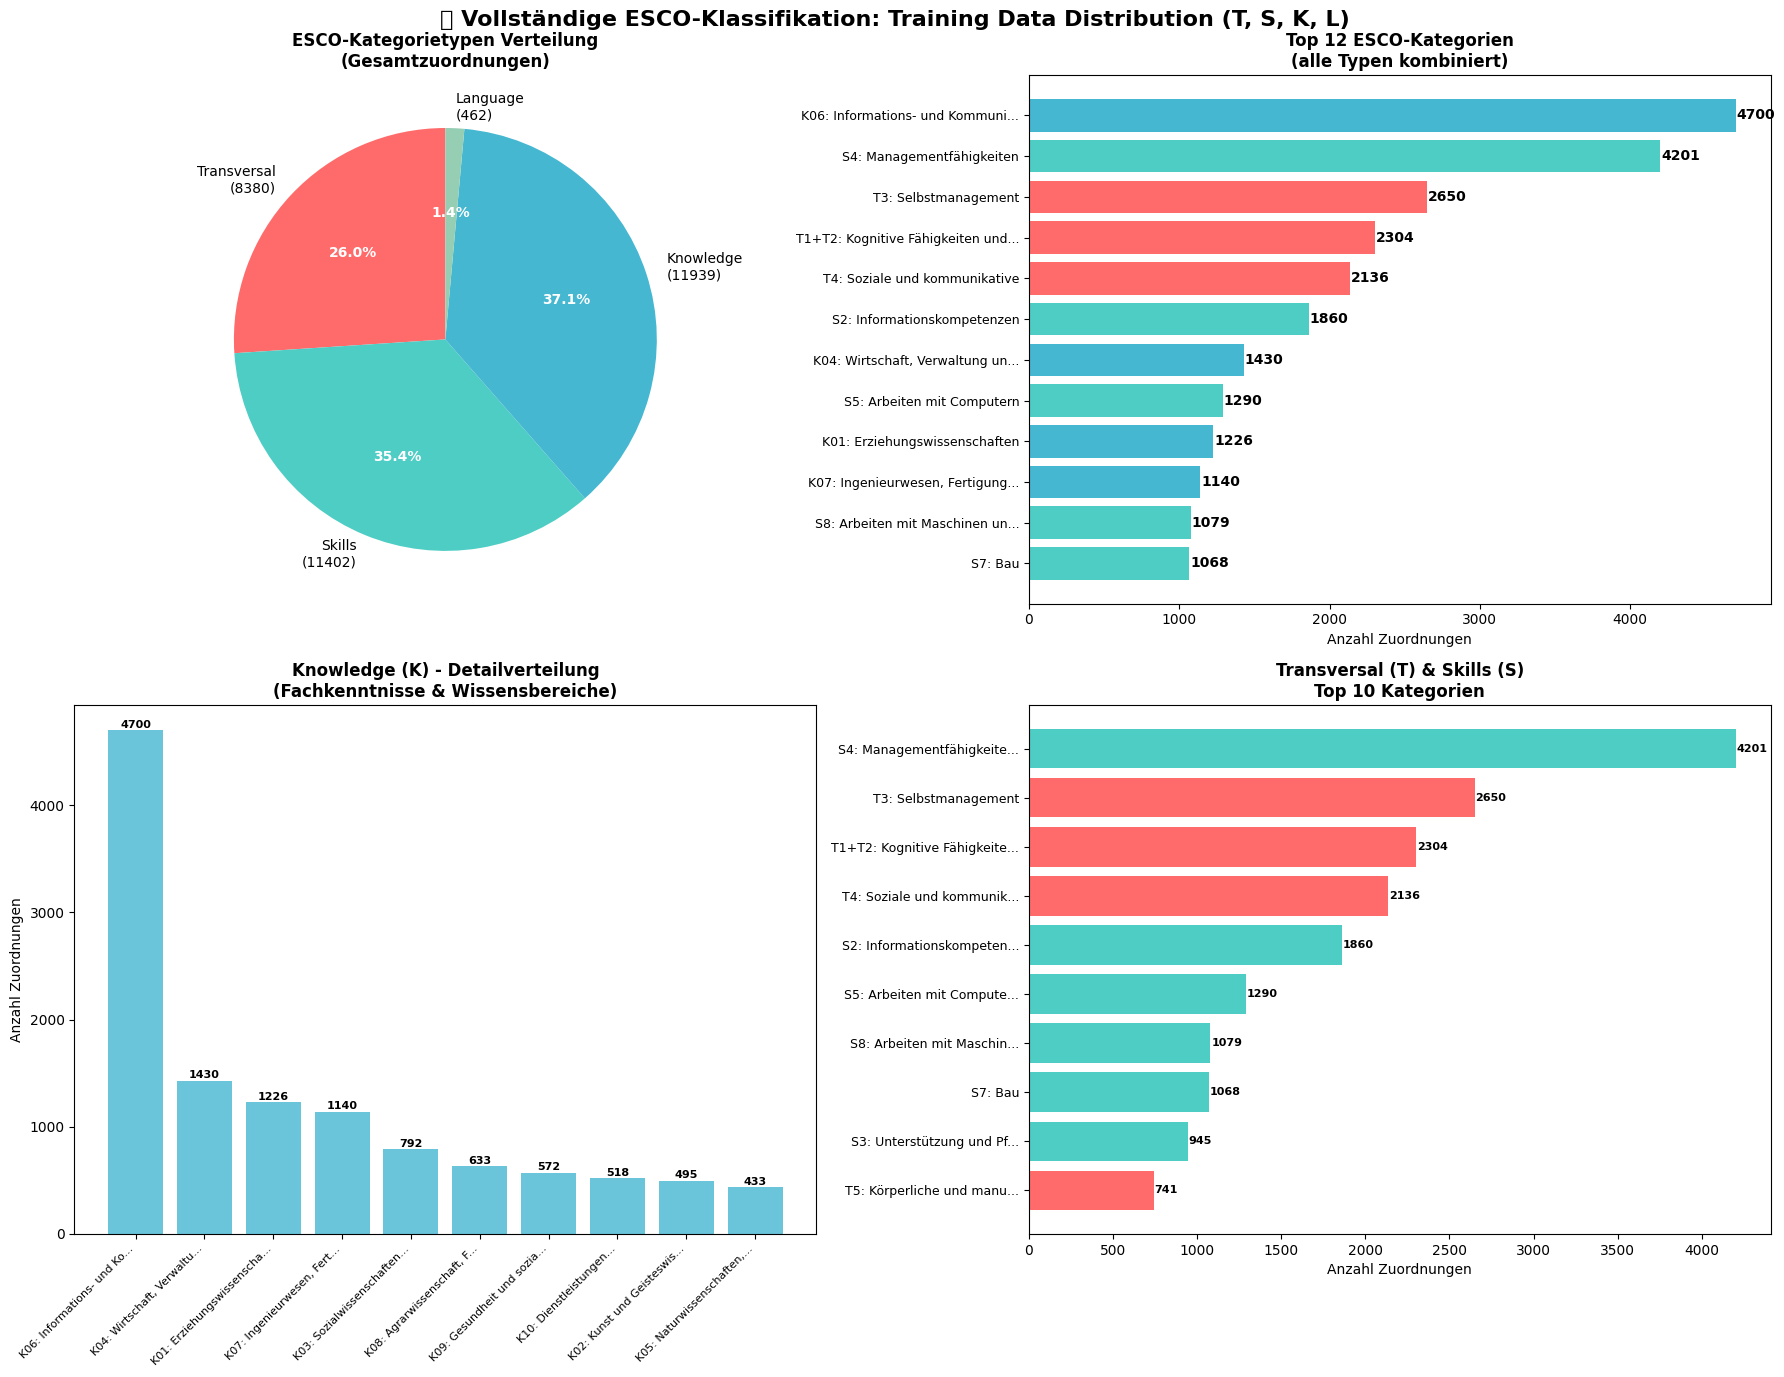

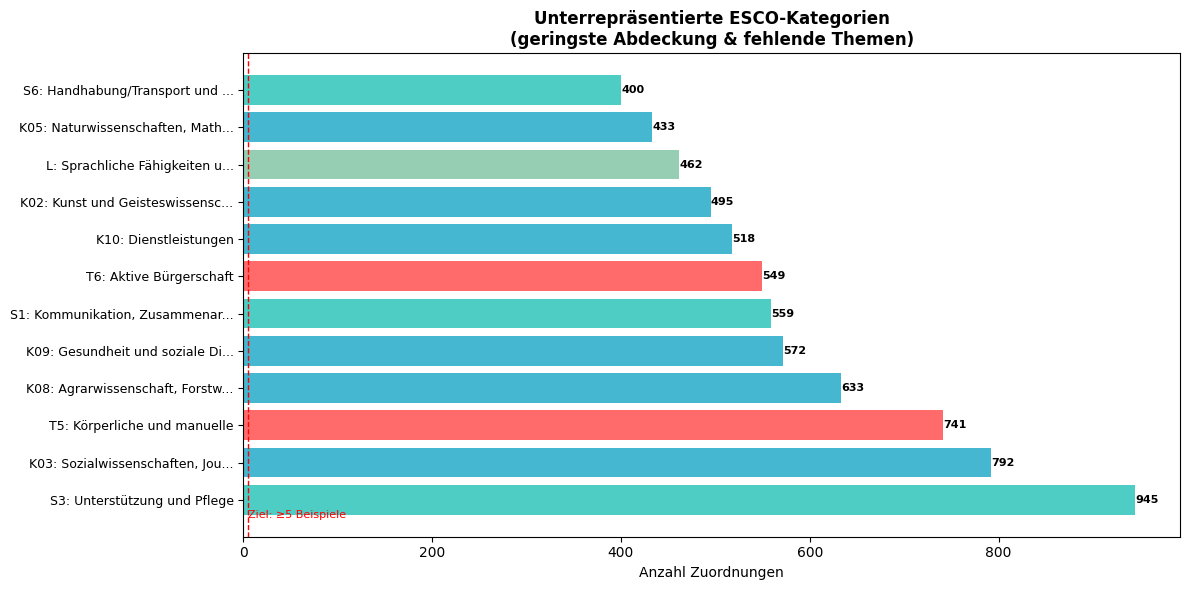


🎯 DETAILLIERTE ESCO-KLASSIFIKATION ANALYSE
📈 ABDECKUNG & VERBESSERUNG:
   • Gesamtqueries analysiert: 6024
   • Mit ESCO klassifiziert: 5937 (98.6%)
   • Unklassifiziert: 87 (1.4%)

📊 KATEGORIE-CHARAKTERISTIKA:
------------------------------

T - TRANSVERSAL (Querschnittskompetenzen):
   Zuordnungen: 8380 (26.0% der Gesamtzuordnungen)
   Top-Kategorien:
     1. T3: Selbstmanagement (2650, 31.6%)
        📝 Beispiel: "gezielte Schulungen zur Lebensmittelrettung und korrekten Ab..." → [Personal mit Blick auf die Verringerung von Lebensmittelabfällen schulen: Einführung neuer Schulungs- und Personalentwicklungsmaßnahmen, um das Wissen der Mitarbeiter/innen über die Vermeidung von Lebensmittelabfällen und die Wiederverwertung von Lebensmitteln zu fördern. Sicherstellen, dass das Personal die Methoden und Hilfsmittel für die Wiederverwertung von Lebensmitteln kennt, z. B. die Abfalltrennung.]
     2. T1+T2: Kognitive Fähigkeiten und Kompetenzen (2304, 27.5%)
        📝 Beispiel: "Fortbildung

In [13]:
# VISUALISIERUNG DER VOLLSTÄNDIGEN ESCO-KLASSIFIKATION
print("📊 ERWEITERTE ESCO-ANALYSE & VISUALISIERUNG")
print("=" * 50)

# Erstelle umfassende Visualisierungen
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🎯 Vollständige ESCO-Klassifikation: Training Data Distribution (T, S, K, L)', 
             fontsize=16, fontweight='bold')

# 1. Pie Chart: Gesamtverteilung nach ESCO-Kategorietypen
type_totals = {}
for cat_type in ['T', 'S', 'K', 'L']:
    type_totals[cat_type] = sum(cat['count'] for cat in category_distribution[cat_type].values())

type_names = {
    'T': f'Transversal\n({type_totals["T"]})',
    'S': f'Skills\n({type_totals["S"]})', 
    'K': f'Knowledge\n({type_totals["K"]})',
    'L': f'Language\n({type_totals["L"]})'
}

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
type_color_map = {'T': colors[0], 'S': colors[1], 'K': colors[2], 'L': colors[3]}
wedges, texts, autotexts = ax1.pie(type_totals.values(), labels=type_names.values(), 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('ESCO-Kategorietypen Verteilung\n(Gesamtzuordnungen)', fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. Bar Chart: Top ESCO-Kategorien (alle Typen)
all_categories = []
for cat_type in ['T', 'S', 'K', 'L']:
    for cat_code, info in category_distribution[cat_type].items():
        full_name = info['name_de']
        display_name = full_name[:25] + ('...' if len(full_name) > 25 else '')
        all_categories.append({
            'code': cat_code,
            'name': full_name,
            'display_name': display_name,
            'count': info['count'],
            'type': cat_type
        })

existing_codes = {cat['code'] for cat in all_categories}
source_categories = esco_categories if 'esco_categories' in globals() else esco_categories
missing_categories = []
for cat_code, cat_info in source_categories.items():
    if cat_code not in existing_codes:
        full_name = cat_info['name_de']
        missing_categories.append({
            'code': cat_code,
            'name': full_name,
            'display_name': full_name[:25] + ('...' if len(full_name) > 25 else ''),
            'count': 0,
            'type': cat_code[0]
        })

all_categories_with_missing = all_categories + missing_categories

non_zero_categories = [cat for cat in all_categories if cat['count'] > 0]
top_categories = sorted(non_zero_categories, key=lambda x: x['count'], reverse=True)[:12]

if top_categories:
    category_names = [f"{cat['code']}: {cat['display_name']}" for cat in top_categories]
    category_counts = [cat['count'] for cat in top_categories]
    category_colors = [type_color_map[cat['type']] for cat in top_categories]

    bars = ax2.barh(range(len(category_names)), category_counts, color=category_colors)
    ax2.set_yticks(range(len(category_names)))
    ax2.set_yticklabels(category_names, fontsize=9)
    ax2.set_xlabel('Anzahl Zuordnungen')
    ax2.set_title('Top 12 ESCO-Kategorien\n(alle Typen kombiniert)', fontweight='bold')
    ax2.invert_yaxis()

    # Werte zu den Balken hinzufügen
    for i, (bar, count) in enumerate(zip(bars, category_counts)):
        ax2.text(count + 5, i, str(count), va='center', fontweight='bold')
else:
    ax2.axis('off')
    ax2.text(0.5, 0.5, 'Keine Kategorien mit Zuordnungen vorhanden', ha='center', va='center', fontsize=12)

# 3. Detailed breakdown: Knowledge (K) categories
k_categories = sorted(category_distribution['K'].items(), key=lambda x: x[1]['count'], reverse=True)
if k_categories:
    k_names = [f"K{item[0][1:]}: {item[1]['name_de'][:20]}..." for item in k_categories]
    k_counts = [item[1]['count'] for item in k_categories]
    
    bars_k = ax3.bar(range(len(k_names)), k_counts, color='#45B7D1', alpha=0.8)
    ax3.set_xticks(range(len(k_names)))
    ax3.set_xticklabels(k_names, rotation=45, ha='right', fontsize=8)
    ax3.set_ylabel('Anzahl Zuordnungen')
    ax3.set_title('Knowledge (K) - Detailverteilung\n(Fachkenntnisse & Wissensbereiche)', fontweight='bold')
    
    # Werte zu den Balken
    for bar, count in zip(bars_k, k_counts):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 3, str(count), 
                ha='center', va='bottom', fontweight='bold', fontsize=8)
else:
    ax3.axis('off')
    ax3.text(0.5, 0.5, 'Keine Knowledge-Kategorien erkannt', ha='center', va='center', fontsize=12)

# 4. Transversal & Skills breakdown
combined_ts = []
for cat_type in ['T', 'S']:
    for cat_code, info in category_distribution[cat_type].items():
        combined_ts.append({
            'code': cat_code,
            'name': info['name_de'][:20] + ('...' if len(info['name_de']) > 20 else ''),
            'count': info['count'],
            'type': cat_type
        })

combined_ts_sorted = sorted(combined_ts, key=lambda x: x['count'], reverse=True)[:10]

if combined_ts_sorted:
    ts_names = [f"{cat['code']}: {cat['name']}" for cat in combined_ts_sorted]
    ts_counts = [cat['count'] for cat in combined_ts_sorted]
    ts_colors = [type_color_map[cat['type']] for cat in combined_ts_sorted]

    bars_ts = ax4.barh(range(len(ts_names)), ts_counts, color=ts_colors)
    ax4.set_yticks(range(len(ts_names)))
    ax4.set_yticklabels(ts_names, fontsize=9)
    ax4.set_xlabel('Anzahl Zuordnungen')
    ax4.set_title('Transversal (T) & Skills (S)\nTop 10 Kategorien', fontweight='bold')
    ax4.invert_yaxis()

    # Werte zu den Balken
    for i, (bar, count) in enumerate(zip(bars_ts, ts_counts)):
        ax4.text(count + 5, i, str(count), va='center', fontweight='bold', fontsize=8)
else:
    ax4.axis('off')
    ax4.text(0.5, 0.5, 'Keine Transversal- oder Skills-Kategorien erkannt', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# Visualisierung der unterrepräsentierten Kategorien
least_categories = sorted(all_categories_with_missing, key=lambda x: x['count'])[:12]
fig_low, ax_low = plt.subplots(1, 1, figsize=(12, 6))
if least_categories:
    least_names = [f"{cat['code']}: {cat['display_name']}" for cat in least_categories]
    least_counts = [cat['count'] for cat in least_categories]
    least_colors = [type_color_map.get(cat['type'], '#BBBBBB') for cat in least_categories]

    bars_low = ax_low.barh(range(len(least_names)), least_counts, color=least_colors)
    ax_low.set_yticks(range(len(least_names)))
    ax_low.set_yticklabels(least_names, fontsize=9)
    ax_low.set_xlabel('Anzahl Zuordnungen')
    ax_low.set_title('Unterrepräsentierte ESCO-Kategorien\n(geringste Abdeckung & fehlende Themen)', fontweight='bold')
    ax_low.invert_yaxis()

    for i, (bar, count) in enumerate(zip(bars_low, least_counts)):
        ax_low.text(count + 0.2, i, str(count), va='center', fontweight='bold', fontsize=8)

    # Schwellenlinie z.B. 5 Beispiele als Mindestziel
    ax_low.axvline(x=5, color='red', linestyle='--', linewidth=1)
    ax_low.text(5 + 0.2, len(least_names) - 0.5, 'Ziel: ≥5 Beispiele', color='red', fontsize=8)
else:
    ax_low.axis('off')
    ax_low.text(0.5, 0.5, 'Keine Kategorien zur Analyse verfügbar', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# DETAILLIERTE ANALYSE DER ERGEBNISSE
print(f"\n🎯 DETAILLIERTE ESCO-KLASSIFIKATION ANALYSE")
print("=" * 50)

print(f"📈 ABDECKUNG & VERBESSERUNG:")
print(f"   • Gesamtqueries analysiert: {len(comprehensive_classifications)}")
print(f"   • Mit ESCO klassifiziert: {comprehensive_classified} ({comprehensive_classified/len(comprehensive_classifications)*100:.1f}%)")
print(f"   • Unklassifiziert: {comprehensive_unclassified} ({comprehensive_unclassified/len(comprehensive_classifications)*100:.1f}%)")

print(f"\n📊 KATEGORIE-CHARAKTERISTIKA:")
print("-" * 30)

least_non_zero = [cat for cat in least_categories if cat['count'] > 0][:5]
least_zero = [cat for cat in least_categories if cat['count'] == 0][:5]

# Analyse nach Kategorietypen
for cat_type in ['T', 'S', 'K', 'L']:
    type_names_full = {
        'T': 'TRANSVERSAL (Querschnittskompetenzen)',
        'S': 'SKILLS (Spezifische Fähigkeiten)', 
        'K': 'KNOWLEDGE (Fachwissen & -kenntnisse)',
        'L': 'LANGUAGE (Sprachkompetenzen)'
    }
    
    type_total = type_totals[cat_type]
    coverage = (type_total / sum(type_totals.values())) * 100 if sum(type_totals.values()) else 0
    
    print(f"\n{cat_type} - {type_names_full[cat_type]}:")
    print(f"   Zuordnungen: {type_total} ({coverage:.1f}% der Gesamtzuordnungen)")
    
    if category_distribution[cat_type]:
        sorted_cats = sorted(category_distribution[cat_type].items(), 
                           key=lambda x: x[1]['count'], reverse=True)
        
        print(f"   Top-Kategorien:")
        for i, (cat_code, info) in enumerate(sorted_cats[:3]):
            percentage = (info['count'] / type_total) * 100 if type_total else 0
            print(f"     {i+1}. {cat_code}: {info['name_de']} ({info['count']}, {percentage:.1f}%)")
            
            # Zeige 1-2 Beispiele
            if info['examples']:
                example = info['examples'][0]
                query_short = example['query'][:60] + "..." if len(example['query']) > 60 else example['query']
                labels_short = ", ".join(example['labels'][:2])
                if len(example['labels']) > 2:
                    labels_short += f", ... (+{len(example['labels'])-2} weitere)"
                print(f"        📝 Beispiel: \"{query_short}\" → [{labels_short}]")

if least_non_zero:
    print(f"\n🔍 Unterrepräsentierte Kategorien (mit wenigen Beispielen):")
    for cat in least_non_zero:
        print(f"   ⚠️ {cat['code']}: {cat['name']} – {cat['count']} Trainingsbeispiele")

if least_zero:
    print(f"\n🚨 Noch nicht abgedeckte Kategorien (0 Beispiele):")
    for cat in least_zero:
        print(f"   🚩 {cat['code']}: {cat['name']} – bitte zusätzliche Daten sammeln")

# Spezielle Insights
print(f"\n💡 KEY INSIGHTS:")
print("-" * 15)

# Top-Kategorien Analyse
if all_categories:
    most_common = max(all_categories, key=lambda x: x['count'])
    print(f"🥇 Häufigste Kategorie: {most_common['code']} ({most_common['name']}) mit {most_common['count']} Zuordnungen")
else:
    print("🥇 Keine häufigsten Kategorien verfügbar")

# Kategorietyp Balance
balance_analysis = []
for cat_type, total in type_totals.items():
    percentage = (total / sum(type_totals.values())) * 100 if sum(type_totals.values()) else 0
    balance_analysis.append((cat_type, percentage))

if balance_analysis:
    balance_analysis.sort(key=lambda x: x[1], reverse=True)
    dominant_type = balance_analysis[0]
    weakest_type = balance_analysis[-1]
    friendly_names = {
        'T': 'Transversal',
        'S': 'Skills',
        'K': 'Knowledge',
        'L': 'Language'
    }
    print(f"📊 Kategorietyp-Balance: {friendly_names[dominant_type[0]]} dominiert mit {dominant_type[1]:.1f}%")
    print(f"⚖️ Geringste Abdeckung: {friendly_names[weakest_type[0]]} mit {weakest_type[1]:.1f}% – Kandidat für zusätzliche Daten")

print(f"\n✅ Vollständige ESCO-Analyse mit T/S/K/L-Kategorien abgeschlossen!")
if least_non_zero or least_zero:
    print(f"🎯 Empfehlung: Fokus auf die schwächsten Kategorien legen, um Trainingsdaten auszugleichen!")
else:
    print(f"🎯 Das Training Dataset zeigt eine ausgewogene Mischung aller ESCO-Kompetenztypen!")

## 📈 Detaillierte Datenverteilungs-Analyse

Analysieren wir wie die Daten über verschiedene Dimensionen verteilt sind:

📊 Analysiere Label-Verteilungen...
✅ 9726 positive Labels, 19625 negative Labels
🎯 2304 einzigartige positive Labels
❌ 1667 einzigartige negative Labels

🔝 Top 20 häufigste positive Labels:
   Entspannungstechniken: Verschiedene Methoden und Techniken, die Stress lindern und für körperliche und geistige Ruhe und Entspannung sorgen Hierzu gehören Aktivitäten wie Yoga, Qigong und Tai-Chi.: 16x
   Fachkenntnisse im Bereich Ausbildung: Thema, Inhalt und Methoden der Ausbildung, die durch Recherche und die Teilnahme an Ausbildungskursen erworben werden.: 15x
   Textverarbeitungsprogramme verwenden: Verwenden von Computersoftwareanwendungen zum Gestalten, Bearbeiten, Formatieren und Drucken jeder Art von schriftlichem Material.: 15x
   Grundlagen der künstlichen Intelligenz: Theorien, angewandte Grundsätze, Architekturen und Systeme der künstlichen Intelligenz, wie intelligente Agenten, Multiagentensysteme, Expertensysteme, regelbasierte Systeme, neuronale Netze, Ontologien und Erkenntnisthe

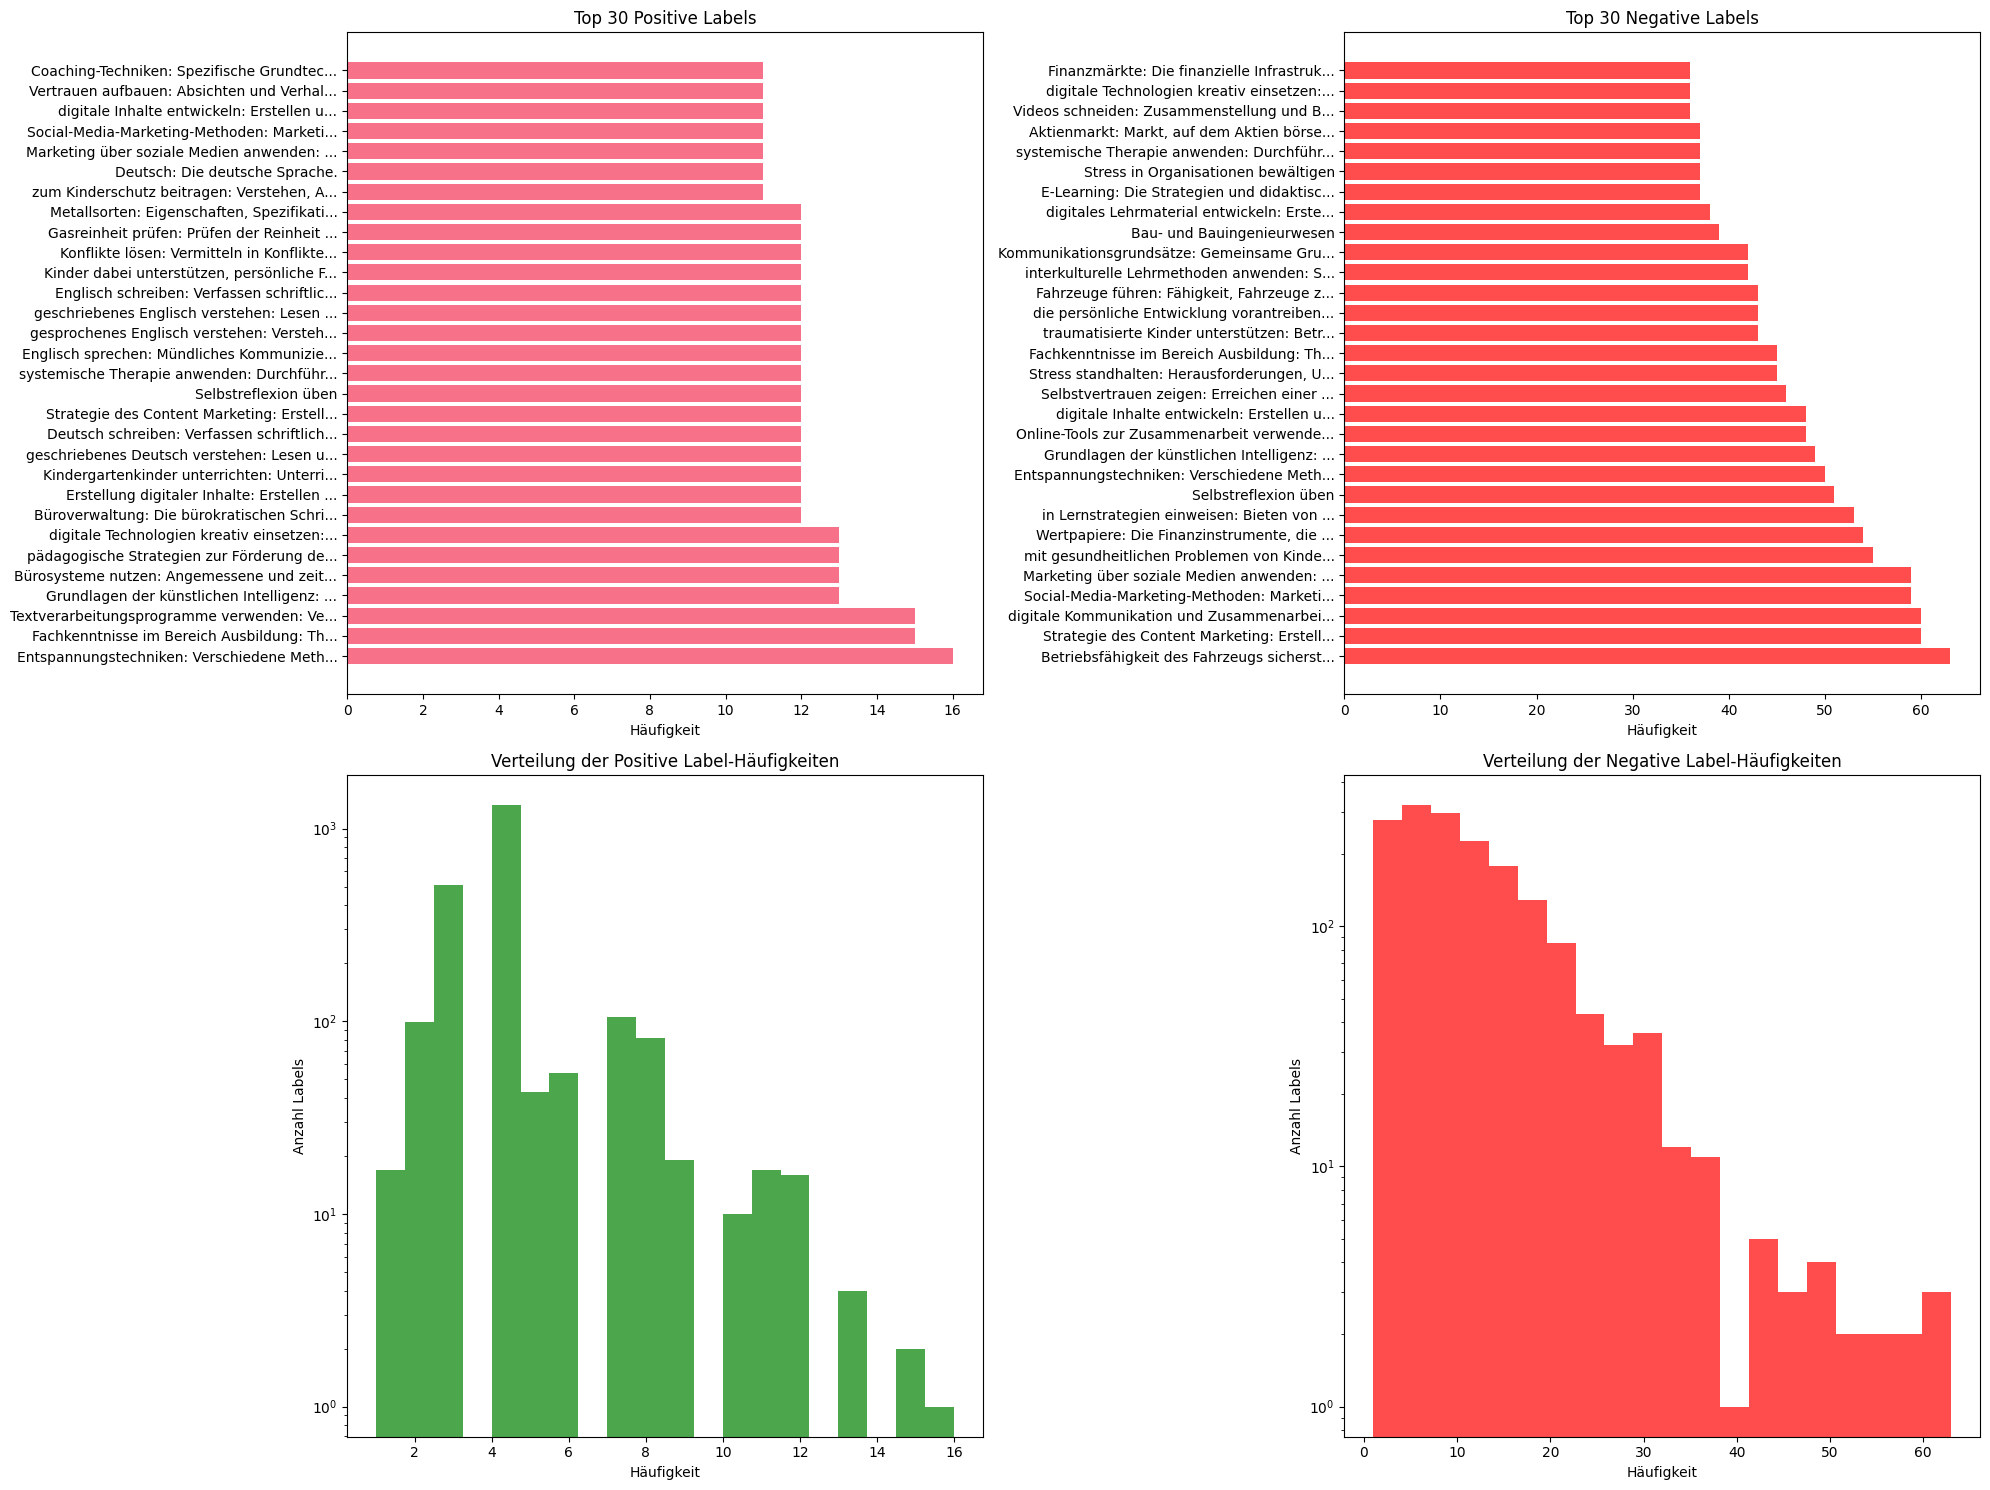


📈 Label-Verteilungs-Statistiken:
Positive Labels - Min: 1, Max: 16, Median: 4.0
Negative Labels - Min: 1, Max: 63, Median: 10.0


In [14]:
# Label-Analyse: Häufigste positive und negative Labels
print("📊 Analysiere Label-Verteilungen...")

# Sammle alle positive und negative Labels getrennt
all_positive_labels = []
all_negative_labels = []

for dataset_name, samples in standardized_datasets.items():
    for sample in samples:
        all_positive_labels.extend(sample["positive_labels"])
        all_negative_labels.extend(sample["negative_labels"])

print(f"✅ {len(all_positive_labels)} positive Labels, {len(all_negative_labels)} negative Labels")
print(f"🎯 {len(set(all_positive_labels))} einzigartige positive Labels")
print(f"❌ {len(set(all_negative_labels))} einzigartige negative Labels")

# Häufigste Labels
pos_counter = Counter(all_positive_labels)
neg_counter = Counter(all_negative_labels)

# Top 20 häufigste positive Labels
print("\n🔝 Top 20 häufigste positive Labels:")
for label, count in pos_counter.most_common(20):
    print(f"   {label}: {count}x")

# Top 20 häufigste negative Labels  
if len(all_negative_labels) > 0:
    print("\n❌ Top 20 häufigste negative Labels:")
    for label, count in neg_counter.most_common(20):
        print(f"   {label}: {count}x")

# Visualisierung der Label-Häufigkeiten
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Positive Label-Verteilung (Top 30)
top_pos = pos_counter.most_common(30)
pos_labels, pos_counts = zip(*top_pos) if top_pos else ([], [])

ax1.barh(range(len(pos_labels)), pos_counts)
ax1.set_xlabel('Häufigkeit')
ax1.set_title('Top 30 Positive Labels')
ax1.set_yticks(range(len(pos_labels)))
ax1.set_yticklabels([label[:40] + '...' if len(label) > 40 else label for label in pos_labels])

# Negative Label-Verteilung (Top 30)
if len(all_negative_labels) > 0:
    top_neg = neg_counter.most_common(30)
    neg_labels, neg_counts = zip(*top_neg) if top_neg else ([], [])
    
    ax2.barh(range(len(neg_labels)), neg_counts, color='red', alpha=0.7)
    ax2.set_xlabel('Häufigkeit')
    ax2.set_title('Top 30 Negative Labels')  
    ax2.set_yticks(range(len(neg_labels)))
    ax2.set_yticklabels([label[:40] + '...' if len(label) > 40 else label for label in neg_labels])
else:
    ax2.text(0.5, 0.5, 'Keine negativen Labels\nverfügbar', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Negative Labels')

# Label-Häufigkeits-Verteilung
pos_freq_dist = list(pos_counter.values())
ax3.hist(pos_freq_dist, bins=20, alpha=0.7, color='green')
ax3.set_xlabel('Häufigkeit')
ax3.set_ylabel('Anzahl Labels')
ax3.set_title('Verteilung der Positive Label-Häufigkeiten')
ax3.set_yscale('log')

if len(all_negative_labels) > 0:
    neg_freq_dist = list(neg_counter.values())
    ax4.hist(neg_freq_dist, bins=20, alpha=0.7, color='red')
    ax4.set_xlabel('Häufigkeit')
    ax4.set_ylabel('Anzahl Labels')
    ax4.set_title('Verteilung der Negative Label-Häufigkeiten')
    ax4.set_yscale('log')
else:
    ax4.text(0.5, 0.5, 'Keine negativen Labels\nverfügbar', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Negative Label-Häufigkeiten')

plt.tight_layout()
plt.show()

# Power-Law Analyse der Label-Verteilung
print(f"\n📈 Label-Verteilungs-Statistiken:")
print(f"Positive Labels - Min: {min(pos_freq_dist)}, Max: {max(pos_freq_dist)}, Median: {np.median(pos_freq_dist)}")
if neg_freq_dist:
    print(f"Negative Labels - Min: {min(neg_freq_dist)}, Max: {max(neg_freq_dist)}, Median: {np.median(neg_freq_dist)}")